# A Hungarian rule for comparatives of adjectives

My name is Rocco van Vreumingen. I'm half Dutch and half Hungarian. I'm very interested in and challenged by Hungarian grammar, when even Hungarian people cannot explain whether grammatical facts are as they are. Given such a fact, is it based on a rule, an exception or neither of both? In this notebook, we will see a rule that determines how a Hungarian comparative of an adjective looks like. Note: this notebook is made such that people who are not familiar with programming, can still read the my main point. 


In [736]:
import phunspell #we need a spellchecker
import pynuspell #we need a second spellchecker for accuracy
import pandas as pd
import numpy as np
from anytree import Node, RenderTree

from requests_html import HTMLSession #we need to scrape words from wikipedia
import requests
from bs4 import BeautifulSoup, Comment


I start by making a dataset of Hungarian adjectives, 
taken from https://en.wiktionary.org/wiki/Category:Hungarian_adjectives and 
https://hu.wiktionary.org/wiki/Kateg%C3%B3ria:magyar_mell%C3%A9knevek . I just do that by just copy-pasting all words, because there are not so much pages to copy from such that web-scraping would be necessary.

Unfortunately some words are not available in one dictionary, so that's why I take two dictionaries and later merge them. 

A lot of words of these dictionaries are not comparable. Luckily there's a list which contains uncomparable words, so we can remove these words from both dictionaries.

I scraped the comparatives with the following functions.

I merged the adjective-comparative dictionaries.

I adjusted some things to make the resulting dataset cleaner. The result is a set with two dictionaries, so that if one fails by some reason, we always have a second. However, because of the merge, these dictionaries are not exactly the same as the Hungarian and English version respectively.

Hereafter I replace all entries 'could not be scraped' by real words manually

In [737]:
adj_comp = pd.read_csv('adj_comp_2cols', index_col=0)
adj_comp = adj_comp.loc[:, ~adj_comp.columns.str.contains('^Unnamed:')]
adj_comp

,adjective,dict1,dict2
0,Amerika-ellenes,Amerika-ellenesebb,NaN
1,aberrált,aberráltabb,NaN
2,ablakos,ablakosabb,NaN
3,abnormis,abnormisabb,NaN
4,abnormális,abnormálisabb,NaN
...,...,...,...
2992,őskori,őskoribb,NaN
2993,ősz,őszebb,NaN
2994,őszi,őszibb,NaN
2995,őszies,ősziesebb,NaN


In Hungarian, there are 14 vowels. We can split them in two ways. One way is back- and front vowels. Back vowels come from our throat, front vowels come from between our tongue and lips. Another way is, some of the vowels are accented. However, just by some exploring, I saw that the 'i' and 'í' have a more difficult behaviour in Hungarian grammar than other front vowels, so I set them apart.

In [738]:
vowels = ['a', 'á', 'e', 'é', 'i', 'í', 'ö', 'ő', 'o', 'ó', 'u', 'ú', 'ü', 'ű']
back_vowels = [vowels[i] for i in [0,1,8,9,10,11]] 
front_vowels = [vowels[i] for i in [2,3,6,7,12,13]] #'i', 'í' excluded
i_vowels = [vowels[i] for i in [4,5]] #these are 'i', 'í'
accented_vowels = [vowels[i] for i in range(1,14,2)]

Before I make a rule for how the comparatives look like, I create a function which simplifies a word. First it removes all consonants. Also, at the end of the simplification it adds a 'v' if the last letter of the original word is a vowel, otherwise it adds a 'c'.

In [739]:
def simplify(word):
    simp = ['s']
    for letter in word:
        if letter in vowels:
            simp.append(letter)
    if word[-1] in vowels:
        simp.append('v') #v from vowel
    else:
        simp.append('c') #c from consonant
    return(''.join(simp))

The next function determines for a dataset how the comparative is compared with its adjective. Whether the comparative is formed by adding 'ebb', 'abb', 'bb' or 'accentuated and bb' like 'barna' - 'barnább', or otherwise.

In [740]:
def comparative_describer(row):
    if row['adjective'] + 'ebb' in [row['dict1'], row['dict2']]:
        return('=+ ebb')
    if row['adjective'] + 'abb' in [row['dict1'], row['dict2']]:
        return('=+ abb')
    if row['adjective'] + 'bb' in [row['dict1'], row['dict2']]:
        return('=+ bb')
    else:
        try:
            if row['adjective'][0:-1] + vowels[vowels.index(row['adjective'][-1])+1] + 'bb' \
            in [row['dict1'], row['dict2']]:
                return('accentuated + bb')
            else:
                return('otherwise')
        except:
            return('otherwise')
    

We add the simplified word to the dataset, as well as the describer above.

In [741]:
adj_comp['simplification'] = adj_comp['adjective'].map(lambda word: simplify(word))
adj_comp['addition describer'] = adj_comp.apply(lambda row: comparative_describer(row), axis=1)
adj_comp

,adjective,dict1,dict2,simplification,addition describer
0,Amerika-ellenes,Amerika-ellenesebb,NaN,seiaeeec,=+ ebb
1,aberrált,aberráltabb,NaN,saeác,=+ abb
2,ablakos,ablakosabb,NaN,saaoc,=+ abb
3,abnormis,abnormisabb,NaN,saoic,=+ abb
4,abnormális,abnormálisabb,NaN,saoáic,=+ abb
...,...,...,...,...,...
2992,őskori,őskoribb,NaN,sőoiv,=+ bb
2993,ősz,őszebb,NaN,sőc,=+ ebb
2994,őszi,őszibb,NaN,sőiv,=+ bb
2995,őszies,ősziesebb,NaN,sőiec,=+ ebb


I set those words apart which had a different addition description than by adding 'abb', 'ebb', 'bb' or 'accentuated + bb'. By some exploring I saw that these few words have exceptional comparatives. So next we only consider the other (non-exceptional) part, which is called 'not_otherwise'.

In [742]:
otherwise = adj_comp.loc[adj_comp['addition describer']=='otherwise']
not_otherwise = adj_comp.loc[adj_comp['addition describer']!='otherwise']
otherwise

,adjective,dict1,dict2,simplification,addition describer
207,bohém,bohémebb/abb,NaN,soéc,otherwise
252,bátor,bátrabb,NaN,sáoc,otherwise
275,bő,bővebb,NaN,sőv,otherwise
389,derék,derekabb,NaN,seéc,otherwise
408,dimbes-dombos,dimbesebb-dombosabb,NaN,sieooc,otherwise
448,dús keblű,dúsabb keblű,NaN,súeűv,otherwise
673,fel,feljebb,NaN,sec,otherwise
949,halk szavú,halkabb szavú,NaN,saaúv,otherwise
1051,hosszú,hosszabb,leghosszabb,soúv,otherwise
1052,hosszú lélegzetű,hosszabb lélegzetű,NaN,soúéeeűv,otherwise


Next I want to create a decision tree, one that looks like the DecisionTreeClassifier of sklearn. My idea is as follows: adjectives can be split by some condition. At every subset of a split, the computer looks if a certain addition describer holds most of the times for the words in this subset. 'Most of the times' can be specified by the threshold parameter below. For example, if threshold = 0.95 and the 'ebb' addition holds 0.97 of the times, the child of this subdataset will be 'ebb'.

The way of splitting is as follows. The first split is by distinguishing words ending with a consonant and those which don't. For both words ending with 'c' and 'v', the next step is adding each of the vowels. For example, a child of a word ending with 'c' could be 'ec', that is, a word ending with a consonant and whose last vowel is 'e'. However, when there are too less child words of the form 'ec', then we skip this child. What 'too less' means, is specified in the parameter 'min_leaf'. This is the minimum number of words a child must have. 

In [743]:
def addition_majority(dataset, simplified_word):
    subdataset = dataset.loc[dataset['simplification'].str.endswith(simplified_word)]
    mostly_added = subdataset['addition describer'].value_counts().idxmax()
    percentage_majority = subdataset['addition describer'].value_counts().max()/len(subdataset)
    return(mostly_added, percentage_majority)

addition_describers = not_otherwise['addition describer'].unique()



def layer_up(parent, threshold=1.0, min_leaf=0):
    output = []
    if parent=='':
        output = ['c', 'v']
    else:
        added_mostly, perc_maj = addition_majority(not_otherwise, parent)
        if perc_maj>= threshold:
            output = [added_mostly]
        else:
            for letter in vowels + ['s']:
                child = letter + parent
                simpl_data = not_otherwise.loc[not_otherwise['simplification'].str.endswith(child)]
                if len(simpl_data) >= min_leaf:
                    output.append(child)
            if len(output) == 0:
                output = [addition_majority(not_otherwise, parent)[0]]
    return(output)


I also made this tree visualizable. 

In [744]:
def ruleVisualisation(threshold=1.0, min_leaf=1):
    root = Node('')
    c = Node('c', parent = root)
    v = Node('v', parent = root)
    
    teller=0
    go_on = True
    while go_on and teller<500:
        go_on = False
        for node in root.descendants:
            if node.is_leaf and node.name not in addition_describers:
                for child in layer_up(node.name, threshold, min_leaf):
                    new_node = Node(child, parent = node)
                go_on = True
            teller+=1
                    
    for pre, fill, node in RenderTree(root):
        print("%s%s" % (pre, node.name))
    return(None)

ruleVisualisation(0.9, 4)

#for pre, fill, node in RenderTree(root):
 #   root = Node('root')
  #  print("%s%s" % (pre, node.name))


├── c
│   ├── ac
│   │   └── =+ abb
│   ├── ác
│   │   └── =+ abb
│   ├── ec
│   │   └── =+ ebb
│   ├── éc
│   │   └── =+ ebb
│   ├── ic
│   │   ├── aic
│   │   │   └── saic
│   │   │       └── =+ abb
│   │   ├── áic
│   │   │   └── =+ abb
│   │   ├── eic
│   │   │   └── =+ ebb
│   │   ├── iic
│   │   │   └── siic
│   │   │       └── =+ ebb
│   │   └── sic
│   │       └── =+ ebb
│   ├── íc
│   │   ├── aíc
│   │   │   └── =+ abb
│   │   ├── eíc
│   │   │   └── =+ ebb
│   │   ├── iíc
│   │   │   └── =+ ebb
│   │   ├── uíc
│   │   │   └── =+ abb
│   │   └── síc
│   │       └── =+ abb
│   ├── öc
│   │   └── =+ ebb
│   ├── őc
│   │   └── =+ ebb
│   ├── oc
│   │   └── =+ abb
│   ├── óc
│   │   └── =+ abb
│   ├── uc
│   │   └── =+ abb
│   ├── úc
│   │   └── =+ abb
│   ├── üc
│   │   └── =+ ebb
│   └── űc
│       └── =+ ebb
└── v
    ├── av
    │   └── accentuated + bb
    ├── ev
    │   └── accentuated + bb
    ├── év
    │   └── =+ bb
    ├── iv
    │   └── =+ bb
    ├── őv
    │   └── =+ b

By trying different choices of threshold and min_leaf and inspecting, I found the following rule, where a picture follows the code.

In [745]:
def rule(word):
    simpl = simplify(word)
    
    if simpl[-1] == 'c': #if last letter of word is not a vowel
        if simpl[-2] in back_vowels:
            return('=+ abb')
        if simpl[-2] in front_vowels:
            return('=+ ebb')
        if simpl[-2] == 'i':
            if len(simpl) == 3: #= 'sic'
                return('=+ ebb')
            else:
                simpl = simpl[:-2] + simpl[-1]
                return(rule(simpl))
        if simpl[-2] == 'í':
            if len(simpl) == 3:
                return('=+ abb')
            else:
                simpl = simpl[:-2] + simpl[-1]
                return(rule(simpl))
        
    if simpl[-1] == 'v': #if last letter of word is a vowel 
        if simpl[-2] != 'i':
            if simpl[-2] in accented_vowels:
                return('=+ bb')
            else:
                return('accentuated + bb')  
        elif simpl[-2] == 'i':
            return('=+ bb')

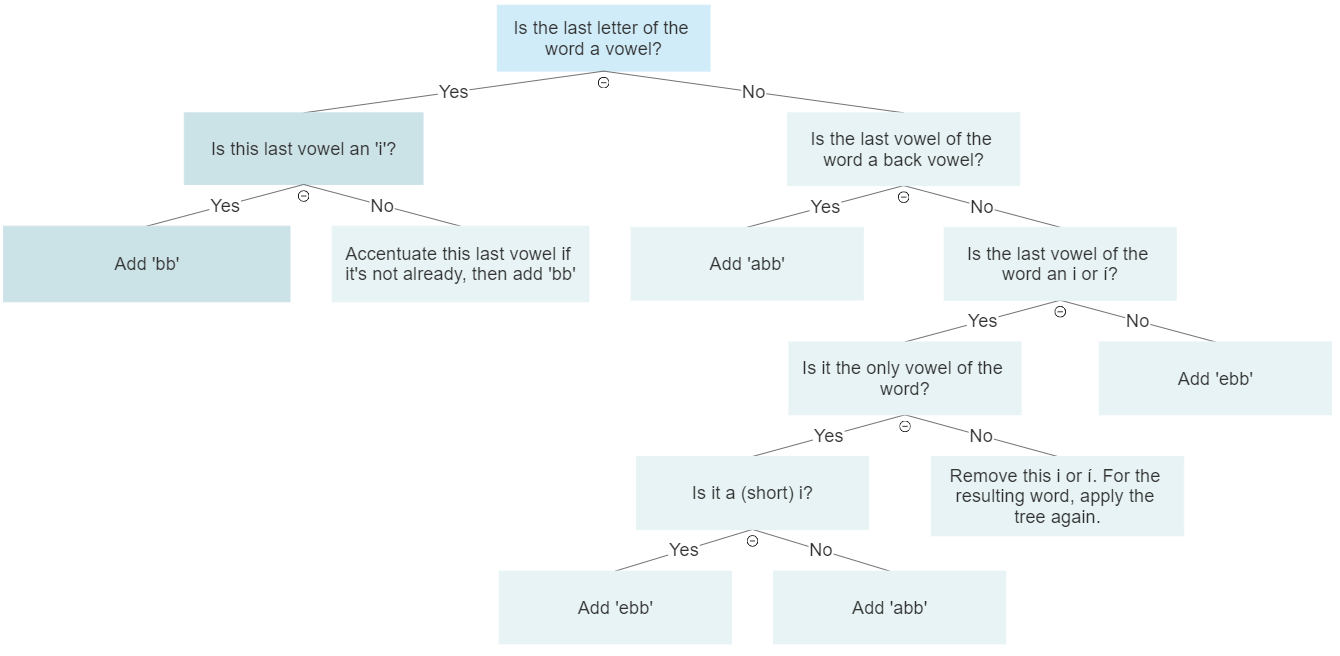

Finally I check how few words of the not_otherwise dataset do not satisfy this rule.

In [746]:
not_otherwise['prediction'] = not_otherwise['adjective'].map(lambda word: rule(word)) 

#not_otherwise.iloc[248:260]

/tmp/ipykernel_4563/2285386004.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_otherwise['prediction'] = not_otherwise['adjective'].map(lambda word: rule(word))


In [747]:
not_otherwise.loc[not_otherwise['prediction'] != not_otherwise['addition describer']]

,adjective,dict1,dict2,simplification,addition describer,prediction
644,fair,fairebb,NaN,saic,=+ ebb,=+ abb
1020,hindu,hindubb,NaN,siuv,=+ bb,accentuated + bb
1080,hív,hívebb,NaN,síc,=+ ebb,=+ abb
1151,infantilis,infantilisabb,infantilisebb,siaiic,=+ ebb,=+ abb
1259,kacér,kacérabb,NaN,saéc,=+ abb,=+ ebb
1398,kompatibilis,kompatibilisebb,NaN,soaiiic,=+ ebb,=+ abb
1459,kávés,kávésabb,NaN,sáéc,=+ abb,=+ ebb
1749,messze,messzebb,legmesszebb,seev,=+ bb,accentuated + bb
1955,ortopéd,ortopédabb,NaN,sooéc,=+ abb,=+ ebb
1957,orvosolatlan,orvosolatlanbb,NaN,soooaac,=+ bb,=+ abb
